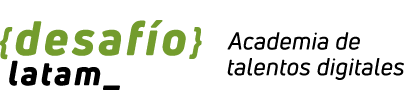
#<center><strong><font color = 'green'>Solución Desafío - Preprocesamiento de datos</font></strong></center>

Se da aquí una sugerencia de resolución del desafío, que puede variar dependiendo de algunas elecciones de los estudiantes.

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings('ignore')

# 1. Cargar Datos y vista inicial

In [98]:
data = pd.read_csv('imdb_anime.csv', encoding='UTF-8')
data.shape

(45717, 13)

In [99]:
data.head()

,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Stars,Certificate,Metascore,Gross,Episode,Episode Title
0,One Piece,"Animation, Action, Adventure","8,9",187.689,24 min,(1999– ),Follows the adventures of Monkey D. Luffy and ...,"Mayumi Tanaka,Laurent Vernin,Akemi Okamura,Ton...",TV-14,NaN,187689,0,NaN
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure","7,4",28.895,99 min,-2023,The film follows the Turtle brothers as they w...,NaN,PG,74,28895,0,NaN
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy","7,1",189.108,92 min,-2023,A plumber named Mario travels through an under...,NaN,PG,46,189108,0,NaN
3,Attack on Titan,"Animation, Action, Adventure","9,1",434.457,24 min,(2013–2023),After his hometown is destroyed and his mother...,"Josh Grelle,Bryce Papenbrook,Yûki Kaji,Yui Ish...",TV-MA,NaN,434457,0,NaN
4,Jujutsu Kaisen,"Animation, Action, Adventure","8,5",82.909,24 min,(2020– ),A boy swallows a cursed talisman - the finger ...,"Junya Enoki,Yûichi Nakamura,Adam McArthur,Yuma...",TV-MA,NaN,82909,0,NaN


# 2. Análisis de Calidad de Datos

In [100]:
def data_quality_analysis(df):
    # Crear un nuevo dataframe para almacenar los resultados
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    # Obtener información general del dataframe
    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().mean() for column in columns]

    # Llenar el nuevo dataframe con los resultados
    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df

In [101]:
# Ejemplo de uso de la función con el dataframe 'df'
analysis_result = data_quality_analysis(data).set_index('Columna')
analysis_result

,Tipo de dato,Valores únicos,Valores faltantes
Columna,,,
Title,object,9851,0.000000
Genre,object,201,0.000000
User Rating,object,87,0.452961
Number of Votes,object,3033,0.452961
Runtime,object,196,0.288033
Year,object,740,0.002756
Summary,object,22588,0.484940
Stars,object,6460,0.700855
Certificate,object,33,0.372356


In [102]:
# Eliminar por exceso de valores faltantes
drop_nan = analysis_result.loc[analysis_result['Valores faltantes']>0.5].index.to_list()
# Eliminar por no entregar información
drop_noinfo = analysis_result.loc[analysis_result['Valores únicos']==1].index.to_list()
# Eliminar por exceso de categorias -> no entregan información generalizable
drop_cats = analysis_result.loc[((analysis_result['Valores únicos']/data.shape[0])>0.5)&(analysis_result['Tipo de dato']=='object')].index.to_list()

drop_quality = set(drop_cats + drop_nan + drop_noinfo)
print(drop_quality)

{'Stars', 'Metascore', 'Episode Title'}


In [103]:
# Ejemplo de uso de la función con el dataframe 'df'
analysis_result_pos_quality = data_quality_analysis(data.drop(drop_quality, axis=1)).set_index('Columna')
analysis_result_pos_quality

,Tipo de dato,Valores únicos,Valores faltantes
Columna,,,
Title,object,9851,0.000000
Genre,object,201,0.000000
User Rating,object,87,0.452961
Number of Votes,object,3033,0.452961
Runtime,object,196,0.288033
Year,object,740,0.002756
Summary,object,22588,0.484940
Certificate,object,33,0.372356
Gross,object,3033,0.452961


In [104]:
data_quality = data.drop(drop_quality, axis=1)

# 3. Análisis Exploratorio Inicial

## Distribuciones

In [105]:
columns_distributions = ['Title', 'User Rating', 'Number of Votes', 'Runtime', 'Year', 'Certificate', 'Gross', 'Episode']

In [106]:
def plot_distributions(data, analysis_result, columns_review=None):
    plt.rcParams.update({'font.size': 25})

    if columns_review:
        columns_distributions = columns_review
    else:
        columns_distributions = data.columns
    plt.figure(figsize=(30, 30))
    number_rows = len(columns_distributions)//2 + len(columns_distributions)%2
    for n, i in enumerate(columns_distributions):
        plt.subplot(5, 2, n + 1)
        if analysis_result.loc[i, 'Tipo de dato']=='object':
            sns.countplot(y= data[i], order=data[i].value_counts().iloc[:7].index)
            plt.title('Frecuencias para {}'.format(i))
        else:
            sns.distplot(data[i])
            plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

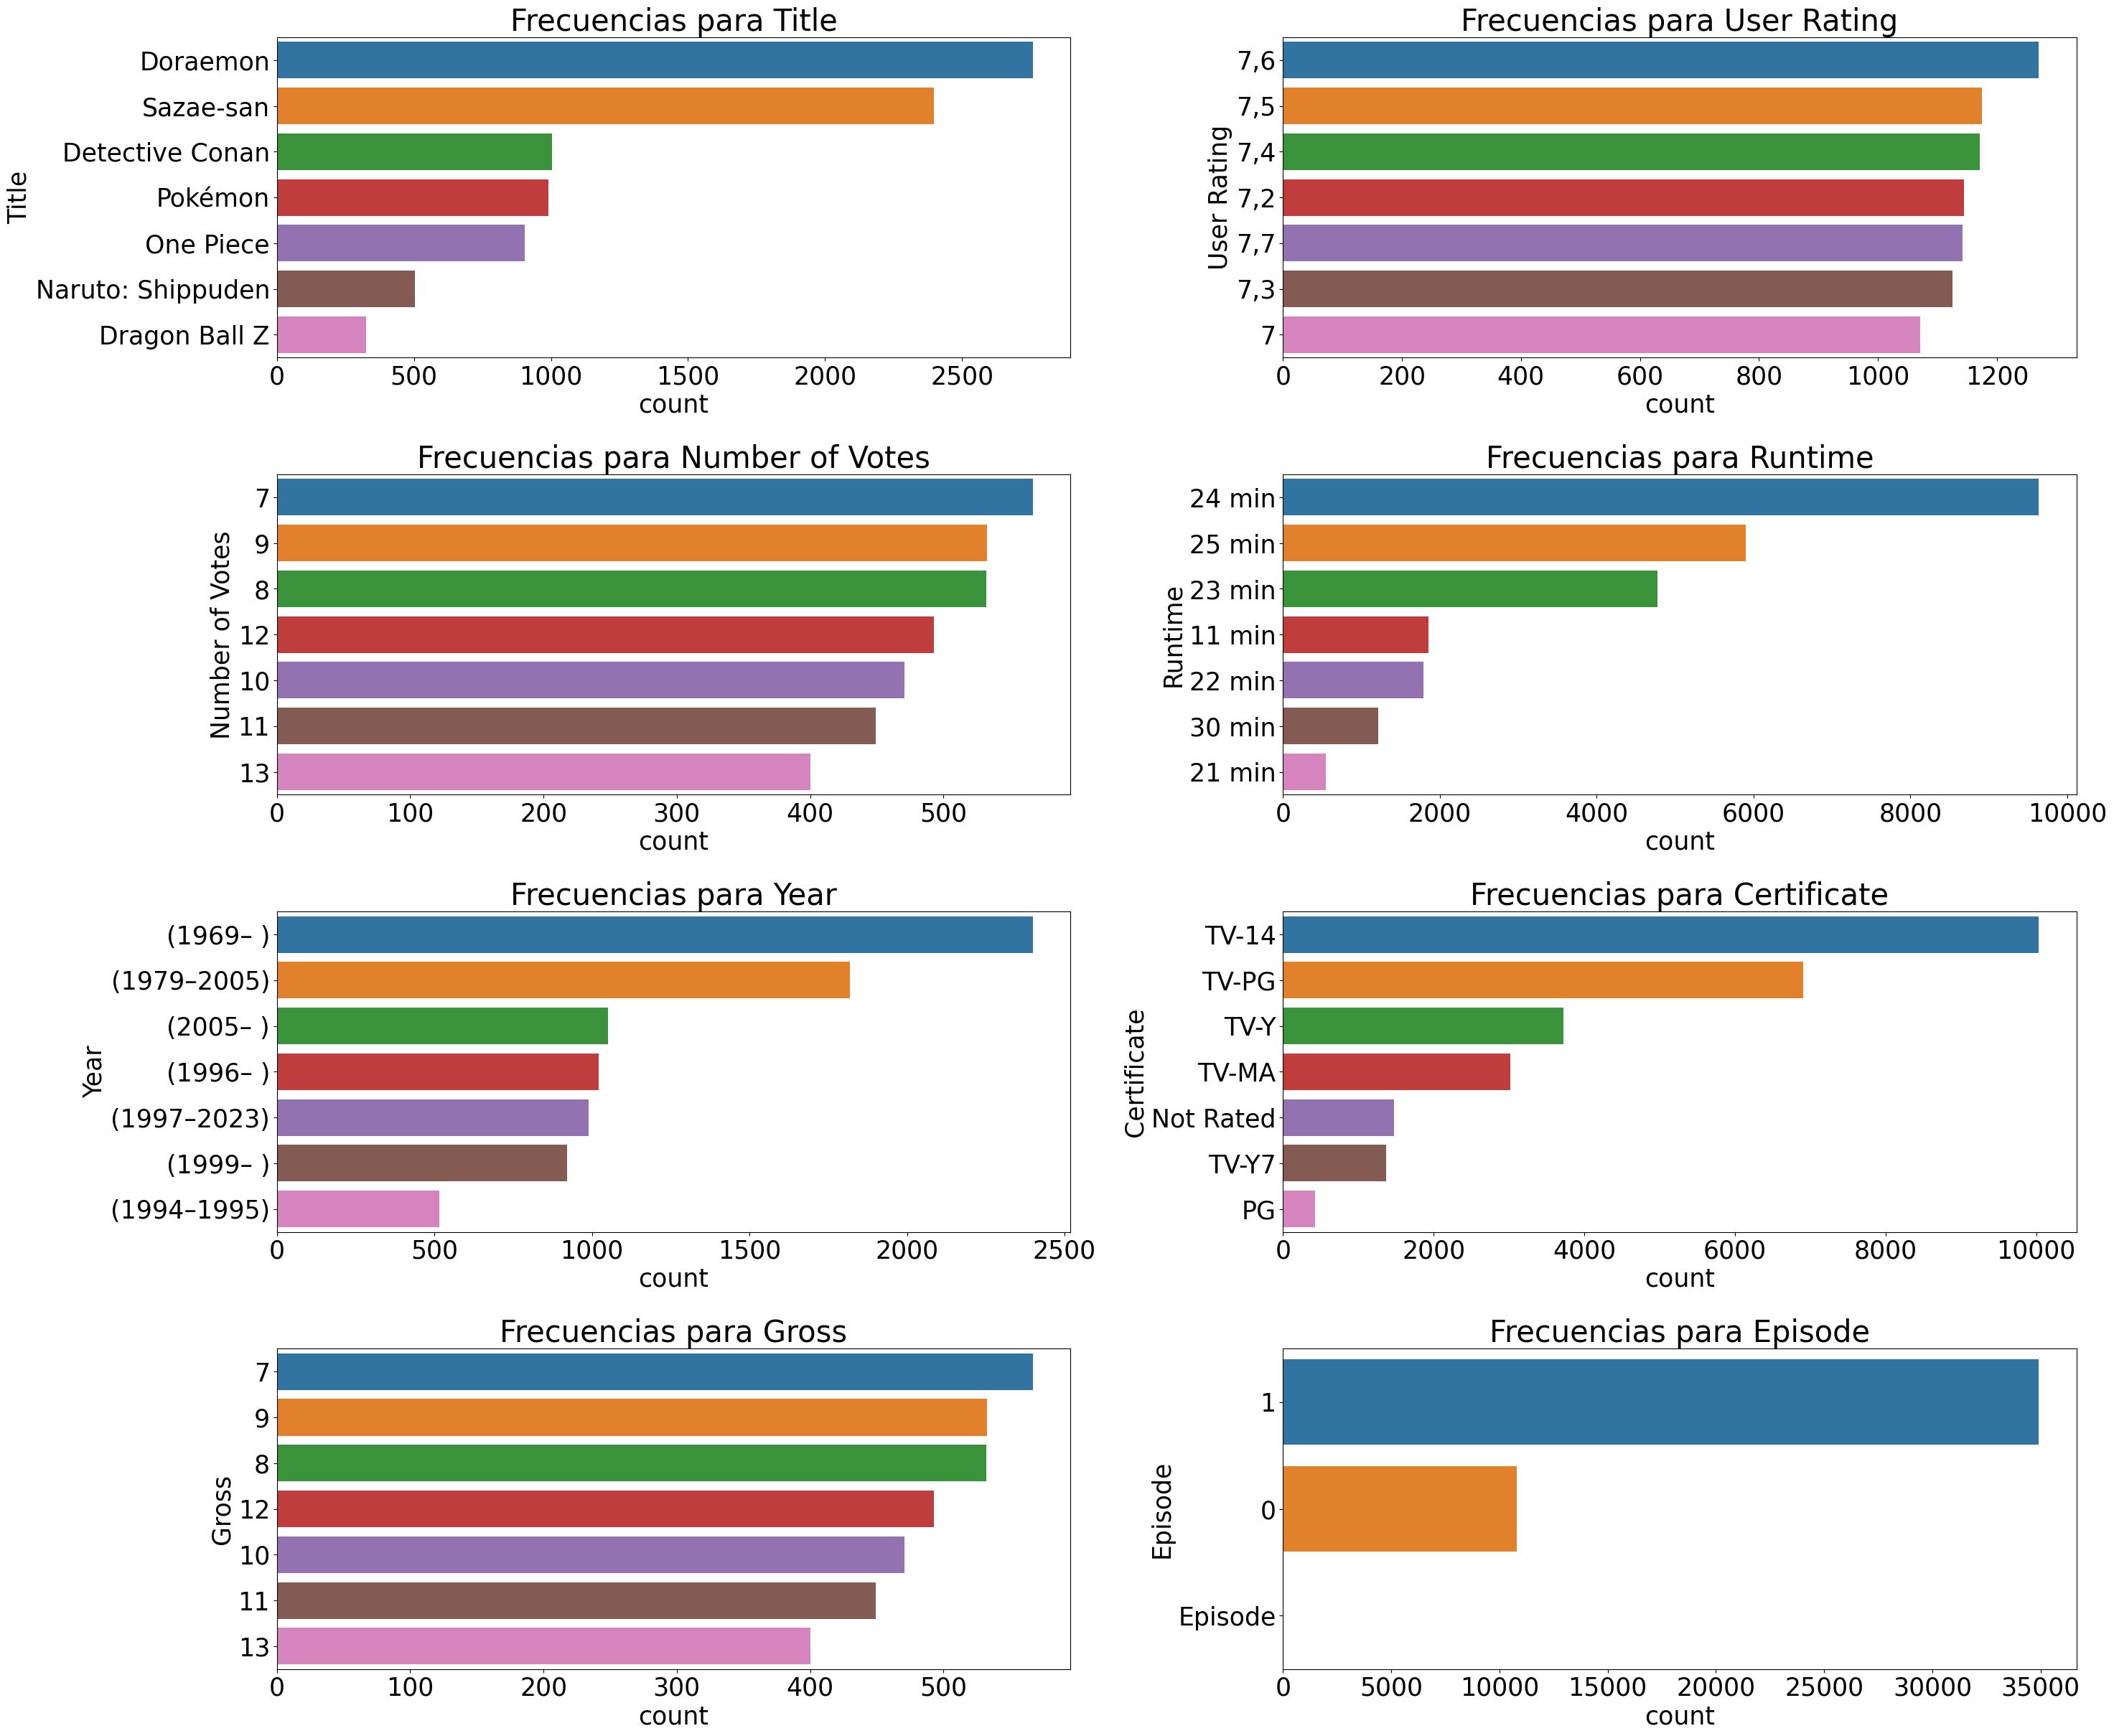

In [107]:
plot_distributions(data_quality, analysis_result, columns_review=columns_distributions)

# 4. Transformaciones de datos Iniciales

In [108]:
def initial_transform(data):
    data2 = data.copy()
    data2['User Rating'] = data2['User Rating'].str.replace('User Rating', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data2['Number of Votes'] = data2['Number of Votes'].str.replace(',', '').str.replace('Number of Votes', 'NaN').str.replace('.', '').astype('float')
    data2['Runtime'] = data2['Runtime'].str.replace(' min', '').str.replace('Runtime', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data2['Year'] = data2['Year'].str.extract('(\d+)', expand=True).astype('float')
    data2['Gross'] = data2['Gross'].str.replace('Gross', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data2['Episode'] = data2['Episode'].str.replace('Episode', 'NaN').astype('float')
    data2 = data2.drop(['Summary'], axis=1)
    return data2



In [109]:
data_transform = initial_transform(data_quality)
data_transform.shape

(45717, 9)

In [110]:
analysis_result_transform = data_quality_analysis(data_transform).set_index('Columna')

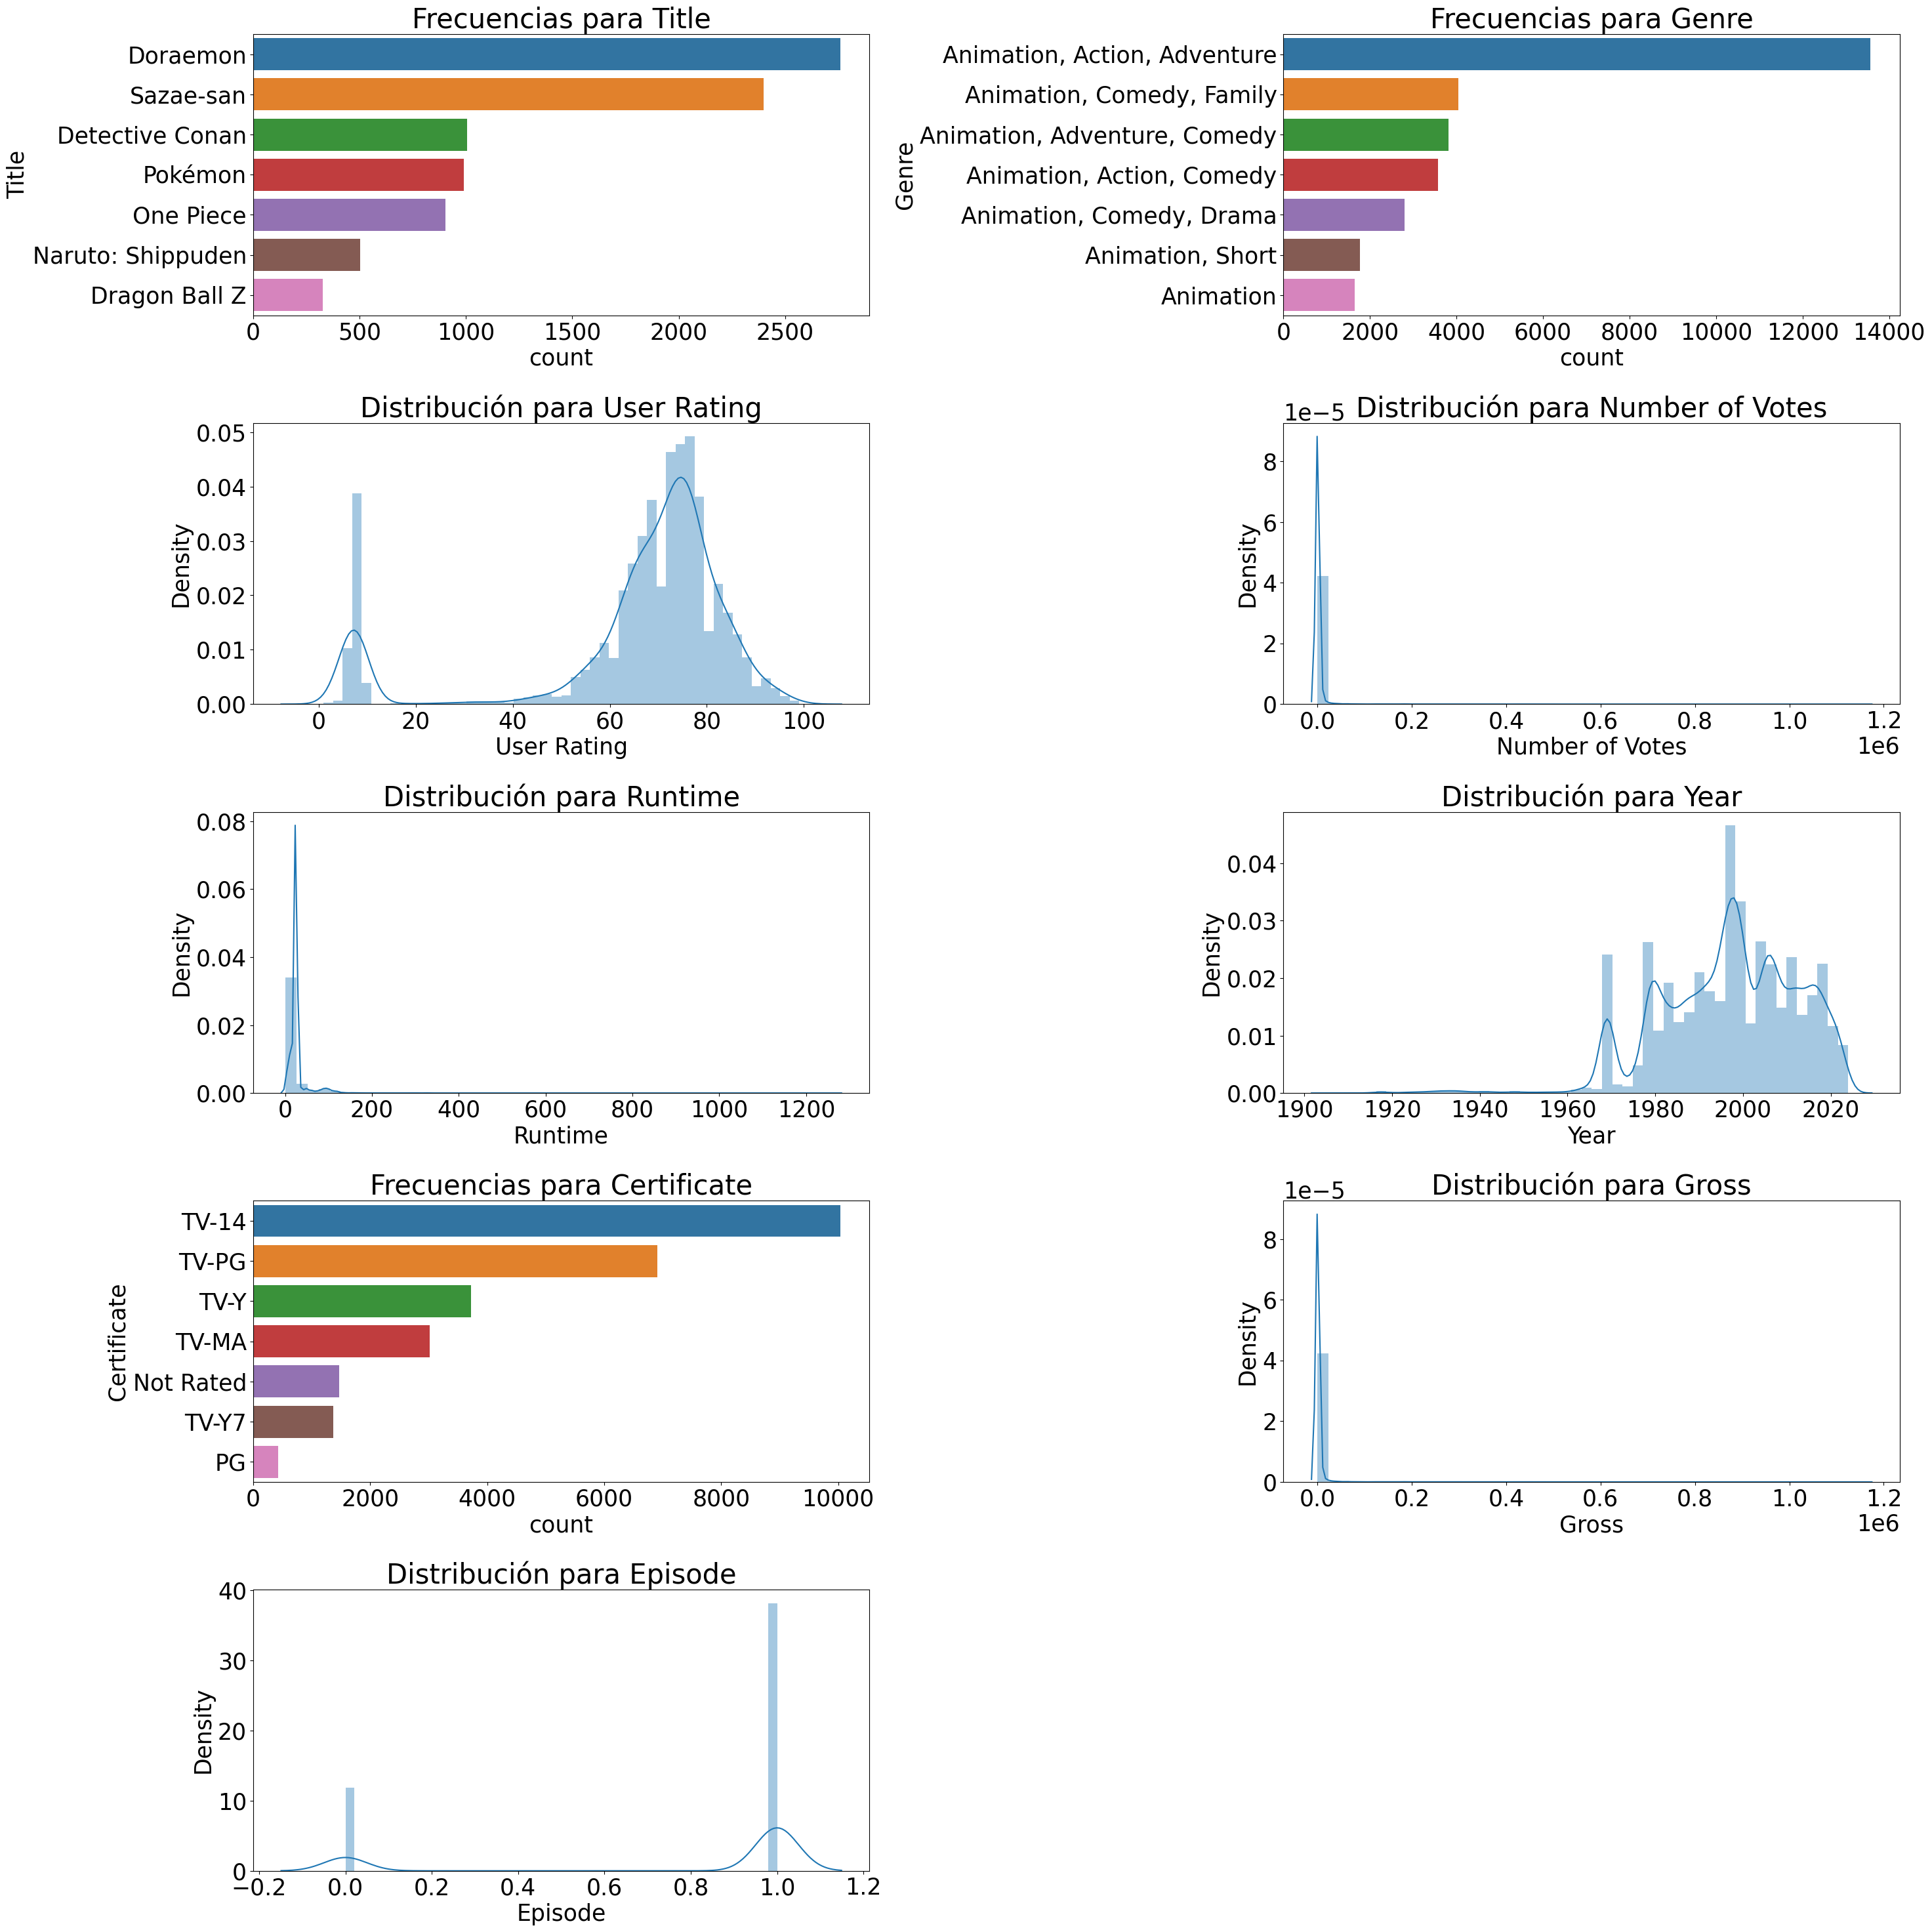

In [111]:
plot_distributions(data_transform, analysis_result_transform, columns_review=None)

# 5. Búsqueda de Outliers - IQR

In [112]:
def detect_outliers_iqr(data, columns, factor=1.5):
    outliers = {}
    idx_outs = set()
    for column_name in columns:
        # Calcular los estadísticos clave
        Q1 = data[column_name].quantile(0.25)
        Q3 = data[column_name].quantile(0.75)
        IQR = Q3 - Q1

        # Calcular los límites para los valores atípicos
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        d_outs = data.loc[(lower_bound>data[column_name])|(data[column_name]>upper_bound)]
        q_outliers = d_outs.shape[0]
        idx_outs.update(set(d_outs.index))
        outliers[column_name] = {'lower_bound': lower_bound, 'upper_bound': upper_bound, 'q': q_outliers}
    outliers = pd.concat([pd.DataFrame.from_dict(outliers), data_transform[columns].describe()]).T
    return outliers, idx_outs

In [113]:
df_outliers, idx_outs = detect_outliers_iqr(data_transform, ['User Rating', 'Number of Votes', 'Runtime', 'Gross'], factor=2)
df_outliers

,lower_bound,upper_bound,q,count,mean,std,min,25%,50%,75%,max
User Rating,38.0,103.0,2772.0,25008.0,65.383397,22.099560,1.0,64.0,72.0,77.0,99.0
Number of Votes,-760.0,1195.0,3264.0,25008.0,2983.802143,31682.381039,5.0,22.0,84.0,413.0,1162284.0
Runtime,19.0,29.0,8671.0,32548.0,27.494654,27.578400,1.0,23.0,24.0,25.0,1271.0
Gross,-760.0,1195.0,3264.0,25008.0,2983.802143,31682.381039,5.0,22.0,84.0,413.0,1162284.0


In [114]:
df_outliers, idx_outs = detect_outliers_iqr(data_transform, ['Number of Votes', 'Runtime', 'Gross'], factor=2)
df_outliers

,lower_bound,upper_bound,q,count,mean,std,min,25%,50%,75%,max
Number of Votes,-760.0,1195.0,3264.0,25008.0,2983.802143,31682.381039,5.0,22.0,84.0,413.0,1162284.0
Runtime,19.0,29.0,8671.0,32548.0,27.494654,27.578400,1.0,23.0,24.0,25.0,1271.0
Gross,-760.0,1195.0,3264.0,25008.0,2983.802143,31682.381039,5.0,22.0,84.0,413.0,1162284.0


In [115]:
data_transform_clean = data_transform.loc[~data_transform.index.isin(idx_outs)]

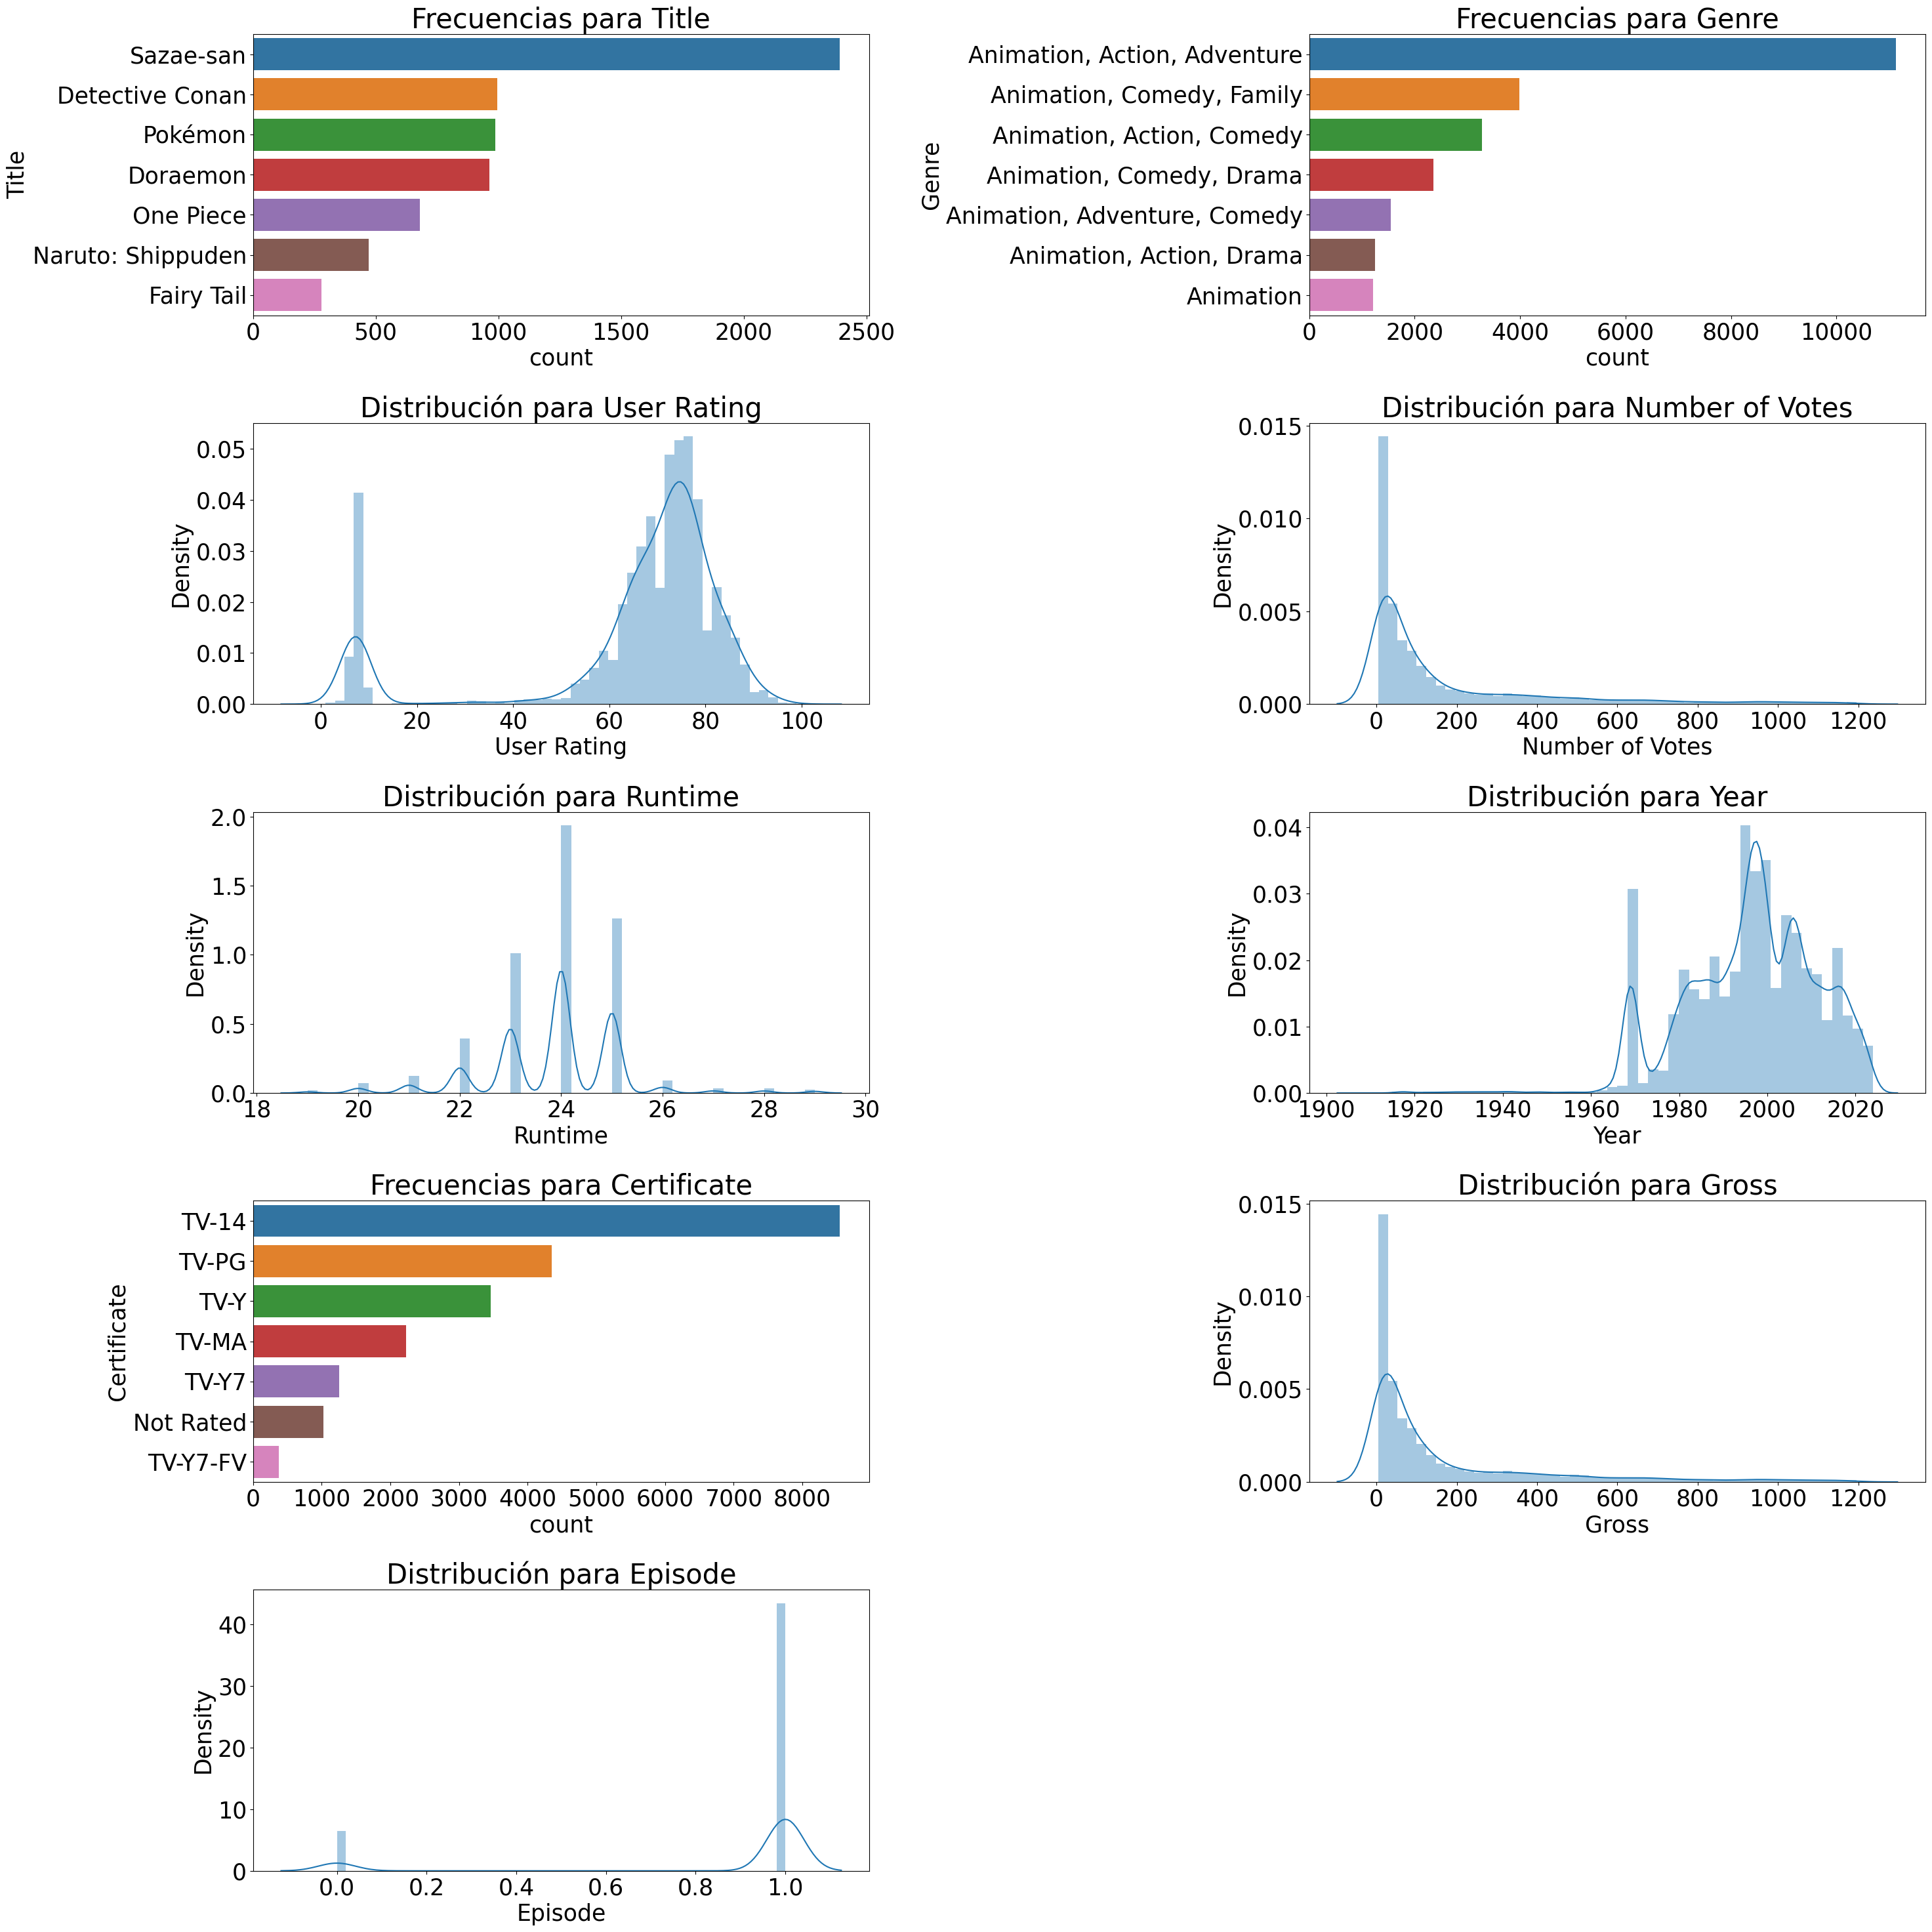

In [116]:
plot_distributions(data_transform_clean, analysis_result_transform, columns_review=None)

# 6. Transformaciones de Variables Finales y Creación de variables

In [117]:
def tranform_final(data):
    data2 = data.copy()
    data2['Genre_n'] = data2['Genre'].str.split(', ').str.len()
    data2['Number of Votes Log'] = np.log(data2['Number of Votes'])
    data2['Gross Log'] = np.log(data2['Gross'])

    data_categories = data2['Genre'].str.split(', ').str.join('|').str.get_dummies()
    data2 = data2.drop(['Genre', 'Certificate', 'Number of Votes', 'Gross'], axis=1)
    data2 = data2.merge(data_categories, left_index=True, right_index=True)
    data2.dropna(inplace=True)
    data2 = data2.reset_index(drop=True)
    return data2

In [118]:
data_final = tranform_final(data_transform_clean)

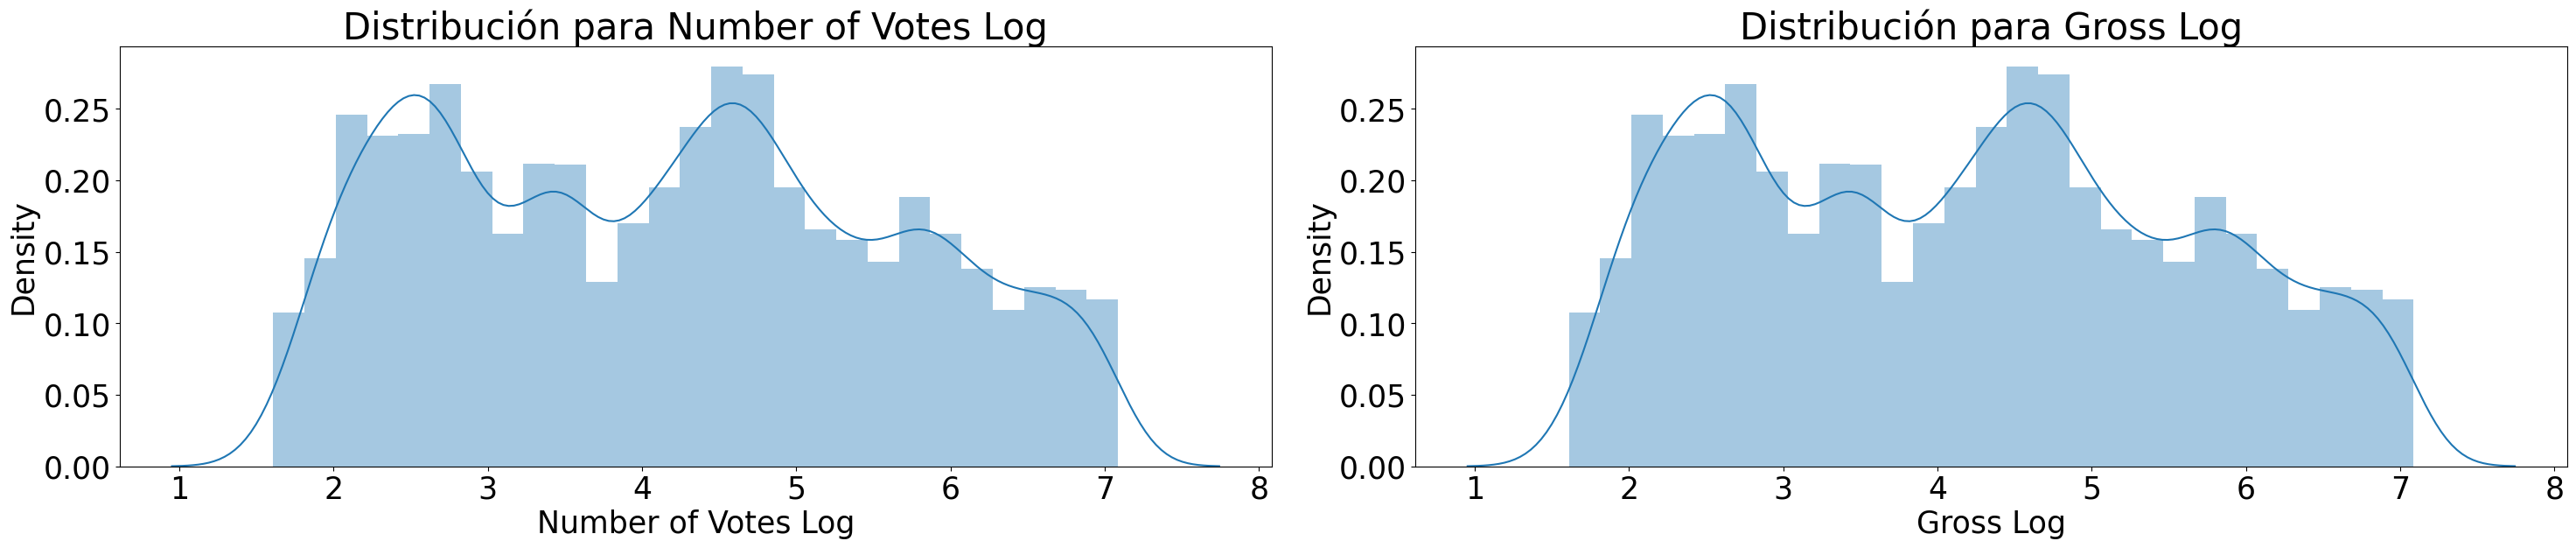

In [119]:
analysis_result = data_quality_analysis(data_final).set_index('Columna')
plot_distributions(data_final, analysis_result, columns_review=['Number of Votes Log', 'Gross Log'])

# 7. Análisis Exploratorio - Correlaciones

In [120]:
correlaciones_pearson = data_final.iloc[:, 1:].corr()

correlaciones_rating = correlaciones_pearson[['User Rating']].abs().sort_values('User Rating', ascending=False)

<Axes: >

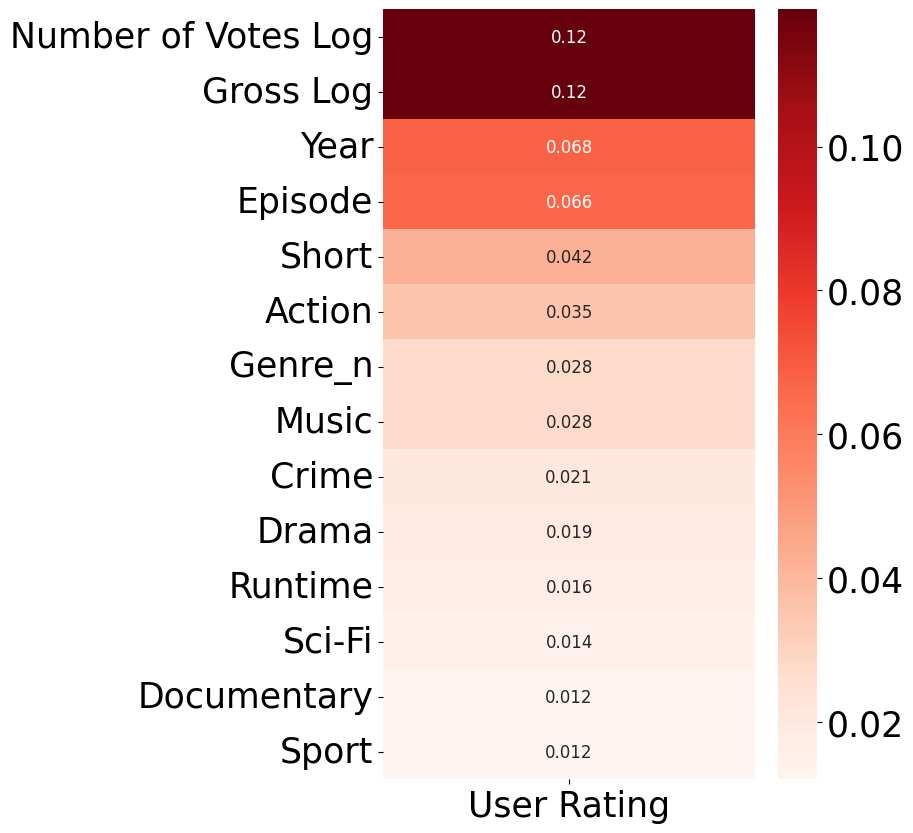

In [121]:
plt.figure(figsize=(6, 10))
sns.heatmap(correlaciones_rating[1:15], cmap='Reds', annot=True, annot_kws={'size':12})


<Axes: xlabel='Gross Log', ylabel='User Rating'>

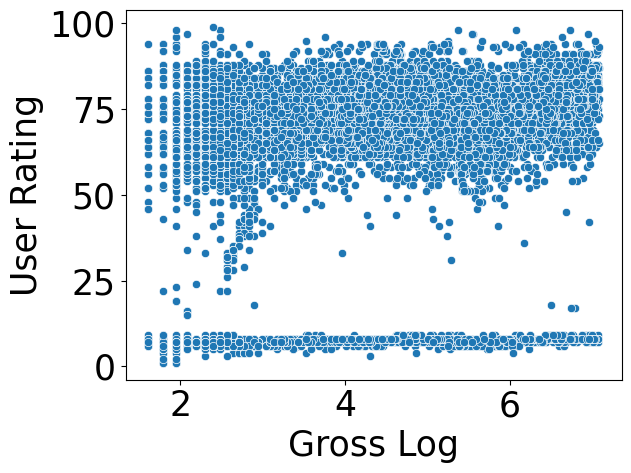

In [122]:
sns.scatterplot(data=data_final, x='Gross Log', y='User Rating')

<Axes: xlabel='Number of Votes Log', ylabel='User Rating'>

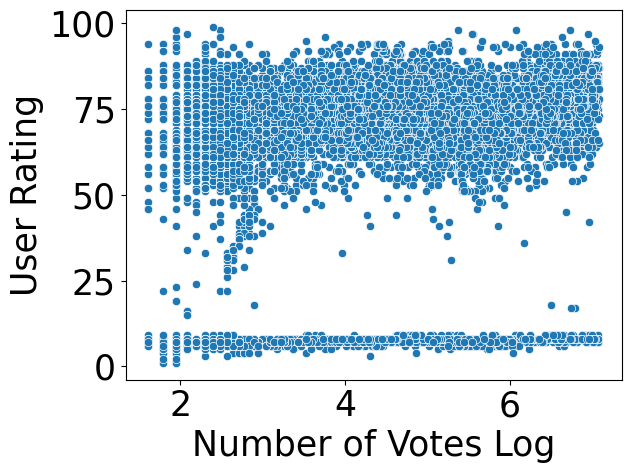

In [123]:
sns.scatterplot(data=data_final, x='Number of Votes Log', y='User Rating')

<Axes: xlabel='Episode', ylabel='User Rating'>

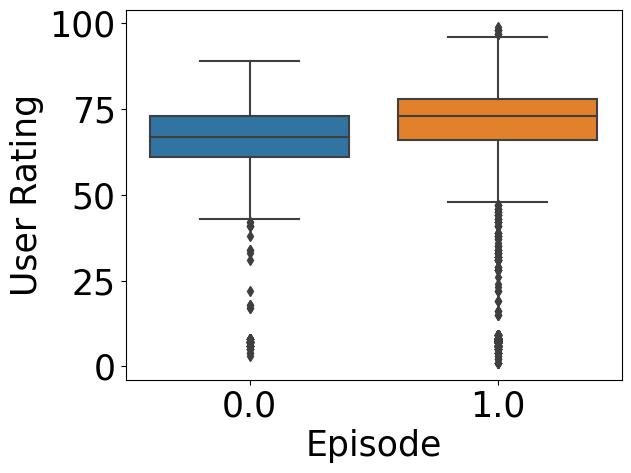

In [124]:
sns.boxplot(data=data_final, x='Episode', y='User Rating')

# 8. Función de procesamiento desde el inicio

In [125]:
def etl_process_imdb_anime(data_input):
    data = data_input.copy()
    analysis_result = data_quality_analysis(data).set_index('Columna')

    # Eliminar por exceso de valores faltantes
    drop_nan = analysis_result.loc[analysis_result['Valores faltantes'] > 0.5].index.to_list()
    # Eliminar por no entregar información
    drop_noinfo = analysis_result.loc[analysis_result['Valores únicos'] == 1].index.to_list()
    # Eliminar por exceso de categorías -> no entregan información generalizable
    drop_cats = analysis_result.loc[((analysis_result['Valores únicos'] / data.shape[0]) > 0.5) & (analysis_result['Tipo de dato'] == 'object')].index.to_list()

    drop_quality = set(drop_cats + drop_nan + drop_noinfo)

    data_quality = data.drop(drop_quality, axis=1)

    data_quality['User Rating'] = data_quality['User Rating'].str.replace('User Rating', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data_quality['Number of Votes'] = data_quality['Number of Votes'].str.replace(',', '').str.replace('Number of Votes', 'NaN').str.replace('.', '').astype('float')
    data_quality['Runtime'] = data_quality['Runtime'].str.replace(' min', '').str.replace('Runtime', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data_quality['Year'] = data_quality['Year'].str.extract('(\d+)', expand=True).astype('float')
    data_quality['Gross'] = data_quality['Gross'].str.replace('Gross', 'NaN').str.replace(',', '').str.replace('.', '').astype('float')
    data_quality['Episode'] = data_quality['Episode'].str.replace('Episode', 'NaN').astype('float')
    data_quality = data_quality.drop(['Summary'], axis=1)

    # Agrega aquí la función 'detect_outliers_iqr' y su llamada

    data_transform_clean = data_quality

    data_transform_clean['Genre_n'] = data_transform_clean['Genre'].str.split(', ').str.len()
    data_transform_clean['Number of Votes Log'] = np.log(data_transform_clean['Number of Votes'])
    data_transform_clean['Gross Log'] = np.log(data_transform_clean['Gross'])

    data_categories = data_transform_clean['Genre'].str.split(', ').str.join('|').str.get_dummies()
    data_transform_clean = data_transform_clean.drop(['Genre', 'Certificate', 'Number of Votes', 'Gross'], axis=1)
    data_transform_clean = data_transform_clean.merge(data_categories, left_index=True, right_index=True)
    data_transform_clean.dropna(inplace=True)
    data_transform_clean = data_transform_clean.reset_index(drop=True)

    return data_transform_clean


In [126]:
data = pd.read_csv('imdb_anime.csv', encoding='latin-1')
data_final = etl_process_imdb_anime(data)

# 9. Selección de variables

## Correlaciones

In [127]:
correlaciones_pearson = data_final.iloc[:, 1:].corr()

correlaciones_rating = correlaciones_pearson[['User Rating']].abs().sort_values('User Rating', ascending=False)
keep_columns = correlaciones_rating[correlaciones_rating>0.001].index

In [128]:
keep_columns

Index(['User Rating', 'Number of Votes Log', 'Gross Log', 'Episode', 'Short',
       'Year', 'Action', 'Genre_n', 'Adventure', 'Sci-Fi', 'Drama', 'Music',
       'Horror', 'Fantasy', 'Mystery', 'History', 'Runtime', 'Family',
       'Thriller', 'Musical', 'Crime', 'Biography', 'Romance', 'Comedy',
       'Documentary', 'Animation', 'Sport', 'War', 'Game-Show', 'Genre',
       'News', 'Reality-TV', 'Talk-Show', 'Western'],
      dtype='object')

## Forward

In [129]:
data_feat = data_final.drop(['Title', 'User Rating'], axis=1)
target = data_final.loc[:, ['User Rating']]

In [130]:
# Crear un modelo base (por ejemplo, Regresión Logística)
base_model = LinearRegression()

# Utilizar Forward Selection para seleccionar características
sfs = SequentialFeatureSelector(base_model, n_features_to_select=10, direction='forward', scoring='neg_mean_absolute_percentage_error', cv=5)
sfs.fit(data_feat, target)
selected_features = data_feat.columns[sfs.support_]
print("Características seleccionadas por Forward Selection:")
print(selected_features)

Características seleccionadas por Forward Selection:
Index(['Year', 'Episode', 'Genre_n', 'Number of Votes Log', 'Action',
       'Adventure', 'Animation', 'Crime', 'Horror', 'Mystery'],
      dtype='object')
